# League of Legends PCA Clustering Analysis

This notebook is my attempt at clustering all the champions in League of Legends based on similar stats and appearance. The scripts that were written to acquire this data from the Riot Developer API is also in the same repo. I start this notebook by reading in the csv containing the name, id, tags, info, and stats of all 147 champions in the data.

I started as I always start, by importing the necessary packages, most interestingly OffsetImage and AnnotationBbox classes from matplotlib so I can create better scatterplots with images of champions instead of their names.

In [1]:
# importing packages
import pandas as pd
import numpy as np
import os

# preprocessing, pca, tsne, and kmeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from skimage.color import rgb2gray
from skimage import filters, img_as_float
import scipy.ndimage as ndi

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# showing images on plots
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Functions

Some functions I wrote in an effort to modularize my code and to make the latter part of the notebook look cleaner.

### num_tags

This function takes the tags (fighter, mage, marksmen, support, etc.) column from my champion dataframe and creates two subsequent dataframe: tags_df, which contains all unique tags with the frequency and combination_df, which has the frequency count of all the *combinations* of tags (for example, teemos is classified as an assassin/mage). 

In [2]:
# takes in the dataframe and outputs the count of all unique tags in a dictionary
def num_tags(df):
    tags = df['tags'].tolist()
    
    # cleaning up strings within each sublist
    clean_tags = []
    for tag in tags:
        clean_tag = tag.replace('[', '').replace(']', '').replace('\'', '')
        clean_tags.append(clean_tag)
        
    # counting the number of occurances of each combination of tags
    combination_dict = {tag: clean_tags.count(tag) for tag in clean_tags}
    
    # flattening all sublists into one list
    clean_tags = [tag.split(',') for tag in clean_tags]
    clean_tags = [tag for subtag in clean_tags for tag in subtag]
    
    # removing any leading white spaces
    clean_tags = [tag.replace(' ', '') for tag in clean_tags]
    
    # counting the number of occurances of each tag
    tags_dict = {tag: clean_tags.count(tag) for tag in clean_tags}  
    
    # converting to dataframe and sorting
    combination_df = pd.Series(combination_dict).to_frame('frequency')
    combination_df.sort_values(by = 'frequency', ascending = False, inplace = True)
    tags_df = pd.Series(tags_dict).to_frame('frequency')
    tags_df.sort_values(by = 'frequency', ascending = False, inplace = True) 
    
    # returns list of sorted dataframes
    return [tags_df, combination_df]

### get_image

Purpose of this is just to have a way to read in an icon of a champion to display over top of its marker in a scatterplot while also being clear and easy to read.

In [3]:
# function that reads in an image from a path
def get_image(path):
    return OffsetImage(plt.imread(path, format = 'PNG'))

### preprocess_images

Function that takes all champion images and preprocesses them for analysis.

In [81]:
def preprocess_images(image_path):
    # creates list of image names to iterate
    image_dir = os.listdir(image_path)
    images = []
    
    # reads each image and converts pixels into numbers
    for png in image_dir:
        img = plt.imread(image_path + png)

        mean_kernel = np.full((3, 3, 3), 1/4)
        img = img[::10, ::10]
        img = ndi.convolve(img, mean_kernel)
        img = img_as_float(img)   
        sigma  = 1
        img = filters.gaussian(img, sigma)
        
        #img = rgb2gray(img)
        # flattens images to lay out 120x120 RGB pixels side by side, resulting in 43200 columns
        img = pd.Series(img.flatten(), name = png.split('.')[0])
        images.append(img)

    image_df = pd.DataFrame(images).reset_index()
    image_df.rename(columns = {'index':'name'}, inplace = True)
    return image_df

## Cleaning and Plotting

Here is where I executed the num_tags function described above and plotted all tags and combinations of tags in descending order. 

In [5]:
# reading data
champs_df = pd.read_csv('https://raw.githubusercontent.com/peanutshawny/league-of-legends/master/data/champions.csv')
champs_df.head()

,key,name,id,tags,image,attack,difficulty,magic,defense,armorPerLevel,...,criticalStrikeChancePerLevel,magicResist,attackDamage,attackspeed,healthHegenPerLevel,magicResistPerLevel,manaRegenPerLevel,movespeed,attackDamagePerLevel,manaPerLevel
0,Aatrox,Aatrox,266,"['Fighter', 'Tank']",https://ddragon.leagueoflegends.com/cdn/9.24.2...,8,4,3,4,3.25,...,0.0,32.1,60.0000,0.651,1.00,1.25,0.000,345.0,5.00,0.0
1,Ahri,Ahri,103,"['Mage', 'Assassin']",https://ddragon.leagueoflegends.com/cdn/9.24.2...,3,5,8,4,3.50,...,0.0,30.0,53.0400,0.668,0.60,0.50,0.800,330.0,3.00,25.0
2,Akali,Akali,84,['Assassin'],https://ddragon.leagueoflegends.com/cdn/9.24.2...,5,7,8,3,3.50,...,0.0,37.0,62.4000,0.625,0.50,1.25,0.000,345.0,3.30,0.0
3,Alistar,Alistar,12,"['Tank', 'Support']",https://ddragon.leagueoflegends.com/cdn/9.24.2...,6,7,5,9,3.50,...,0.0,32.1,61.1116,0.625,0.85,1.25,0.800,330.0,3.62,40.0
4,Amumu,Amumu,32,"['Tank', 'Mage']",https://ddragon.leagueoflegends.com/cdn/9.24.2...,2,3,8,6,3.80,...,0.0,32.1,53.3800,0.736,0.85,1.25,0.525,335.0,3.80,40.0


In [6]:
champs_df.columns

Index(['key', 'name', 'id', 'tags', 'image', 'attack', 'difficulty', 'magic',
       'defense', 'armorPerLevel', 'mana', 'manaRegen', 'criticalStrikeChance',
       'health', 'percentAttackSpeedPerLevel', 'healthPerLevel', 'healthRegen',
       'armor', 'attackRange', 'criticalStrikeChancePerLevel', 'magicResist',
       'attackDamage', 'attackspeed', 'healthHegenPerLevel',
       'magicResistPerLevel', 'manaRegenPerLevel', 'movespeed',
       'attackDamagePerLevel', 'manaPerLevel'],
      dtype='object')

These are all the base stats of each champion in the game, in addition to each Champion's name, id, and key (name without spaces or apostrophes). I'll need to cut out the stats in order to perform PCA and the plotting that follows it.

For now let's take a look at the tags we got from num_tags.

In [7]:
# executing function to get combination of tags and frequencies of individual tags
to_plot = num_tags(champs_df)

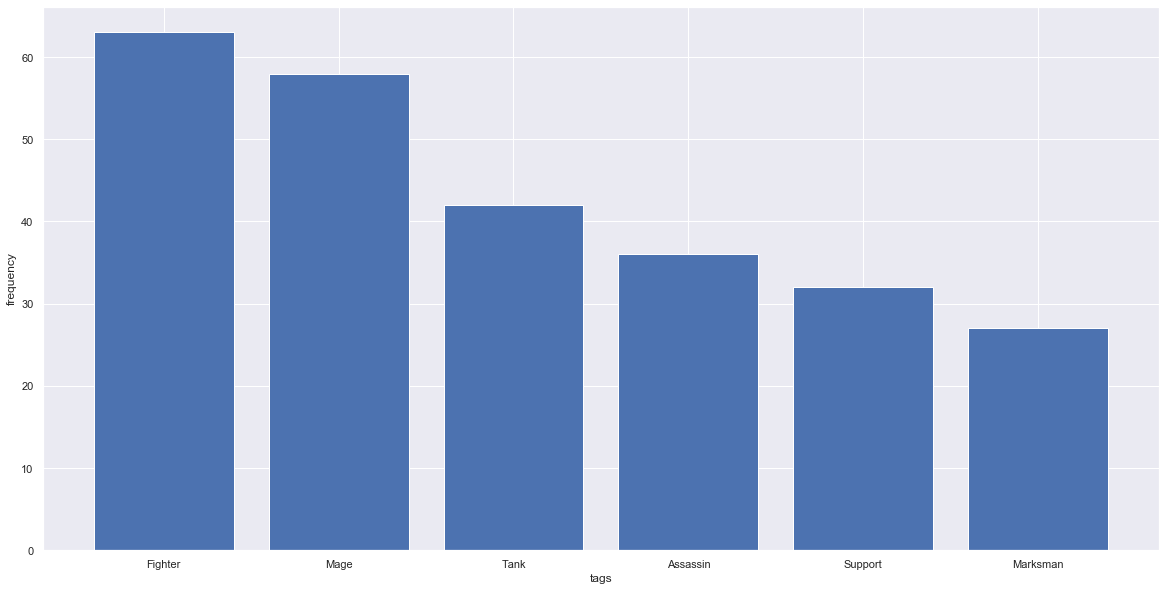

In [8]:
# plotting most common types of individual tags
sns.set()
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(to_plot[0].index.values, to_plot[0]['frequency'], align = 'center')

plt.xlabel('tags')
plt.ylabel('frequency')

plt.show();

Good lord there's a lot of fighters in this game! I guess the fighter tag accounts for basically every single top-lane bruiser (Darius, Jax, Garen, etc.) that can snowball quickly if given kills. Interesting to see Marksman being the least prevalent, maybe because each Marksman in the game is heavily specialized towards only being a Marksman that its rarely accompanied by another secondary tag? Let's take a look at the next plot and see.

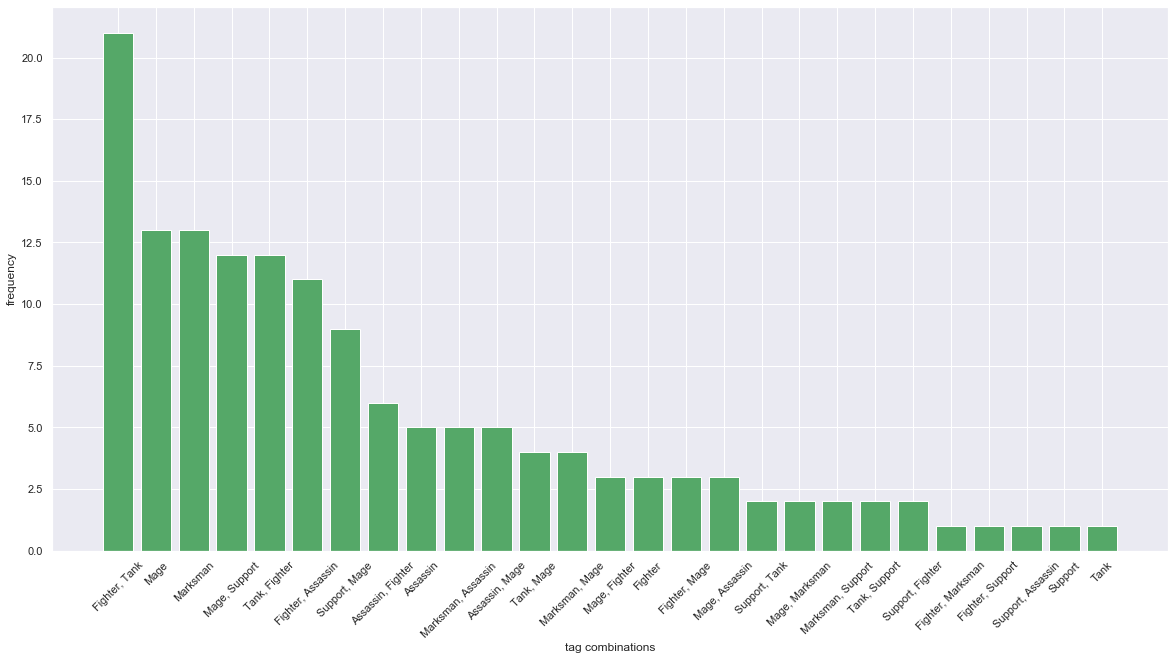

In [9]:
# plotting most common types of combination of tags
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(to_plot[1].index.values, to_plot[1]['frequency'], align = 'center', color = 'g')

plt.xticks(rotation = 45)
plt.xlabel('tag combinations')
plt.ylabel('frequency')

plt.show();

As I suspected, the fighter tag seems to be the most prevalent in the game, either as a primary or secondary tag. I guess to riot, "fighter" basically means any champion that can be played to be a bruiser and has good dueling potential. Marksman, although the least prevalent in the other plot, seems to be the second/third most common when taking into account combinations of tags. This makes sense because aside from some exceptions (Senna, Quinn, Kindred) most marksmen champions as meant to be played a pure ADC's.

All in all, it seems that aside from mages and marksmen, all the other tags are used interchangeably in various combinations such that there aren't many champions that are solely that tag.

## PCA Analysis

I split my champion dataframe into pure champion stats in order to get the data ready to perform principle component analysis, or PCA. 

PCA is, in essence, a dimensionality reduction technique that uses the correlation between dimensions and tries to provide a minimum number of variables that keeps the maximum amount of variation or information about how the original data is distributed. It uses something known as the eigenvalues and eigenvectors of the data-matrix, which I won't go into detail about but basically contains the major directions of variation in the data, which are the directions of maximum variation in a dataset.

For my purposes, I will set the number of principle components to be 2 for the purposes of plotting. It'd be interesting to see what patterns emerge, even if not all the variance is captured.

In [10]:
# splitting up stats to prepare to pca clustering analysis
champs_df_stats = champs_df.drop(['key', 'id', 'tags', 'image'], axis = 1)

In [11]:
champs_df_stats.head()

,name,attack,difficulty,magic,defense,armorPerLevel,mana,manaRegen,criticalStrikeChance,health,...,criticalStrikeChancePerLevel,magicResist,attackDamage,attackspeed,healthHegenPerLevel,magicResistPerLevel,manaRegenPerLevel,movespeed,attackDamagePerLevel,manaPerLevel
0,Aatrox,8,4,3,4,3.25,0.0,0.000,0.0,580.00,...,0.0,32.1,60.0000,0.651,1.00,1.25,0.000,345.0,5.00,0.0
1,Ahri,3,5,8,4,3.50,418.0,8.000,0.0,526.00,...,0.0,30.0,53.0400,0.668,0.60,0.50,0.800,330.0,3.00,25.0
2,Akali,5,7,8,3,3.50,200.0,50.000,0.0,575.00,...,0.0,37.0,62.4000,0.625,0.50,1.25,0.000,345.0,3.30,0.0
3,Alistar,6,7,5,9,3.50,350.0,8.500,0.0,573.36,...,0.0,32.1,61.1116,0.625,0.85,1.25,0.800,330.0,3.62,40.0
4,Amumu,2,3,8,6,3.80,287.2,7.382,0.0,613.12,...,0.0,32.1,53.3800,0.736,0.85,1.25,0.525,335.0,3.80,40.0


In [12]:
# separating out the features and names, only picking particular features
features = ['difficulty', 'armorPerLevel', 'mana', 'manaRegen',
           'health', 'percentAttackSpeedPerLevel', 'healthPerLevel','healthRegen', 'attackRange',
            'attackDamage', 'attackspeed', 'healthHegenPerLevel',
           'magicResistPerLevel', 'manaRegenPerLevel', 'movespeed', 'attackDamagePerLevel', 'manaPerLevel']
x = champs_df_stats.loc[:, features]
y = champs_df_stats.loc[:, ['name']]

In [13]:
print(champs_df_stats['criticalStrikeChancePerLevel'].unique())
print(champs_df_stats['criticalStrikeChance'].unique())

[0.]
[0.]


I notably took out attack, difficulty, magic, and defense because those are theoretically explained by all the other features. I also took out critical chance and critical chance per level since they are always 0 no matter the champion.

I then plotted the distributions of each remaining stats to check if they are normally distributed, which will dictate which standization method out of scikit learn to use.

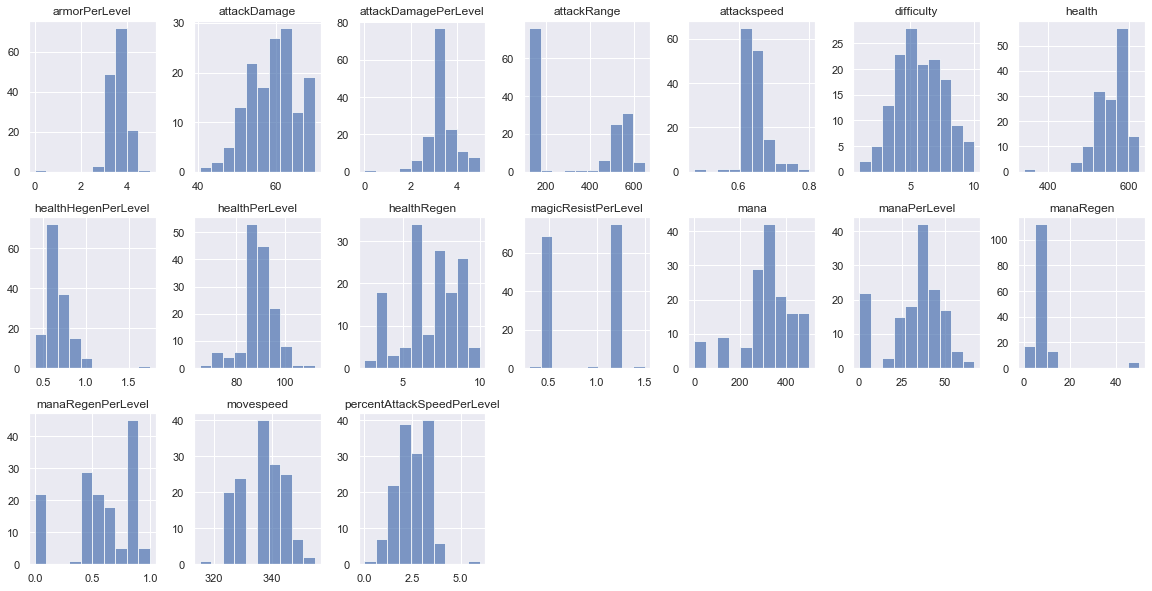

In [14]:
# creating histograms to take a look at distribution of stats
x.hist(figsize = (20, 10), layout = (3,7), alpha = 0.7);

Looks like the stats are really normally distributed. Seems like the MinMaxScaler from scikit learn will be the most useful as its good for data that isn't normally distributed.

In [15]:
# standardizing the features
x_minmax = MinMaxScaler().fit_transform(x)

# pca projection into 2D
pca = PCA(n_components = 2)
principal_components_minmax = pca.fit_transform(x_minmax)

# explained variance ratio
print(pca.explained_variance_ratio_)

[0.44266035 0.17689432]


Looks like my two components added together only explains about 62% of the variance. For the purposes of this plot that should be good enough to discern some patterns in the champion clusters.

In [16]:
# inputting into df for plotting
principal_df = pd.DataFrame(data = principal_components_minmax, 
                           columns = ['principal component 1', 'principal component 2'])

# recombining champion names and components
final_df = pd.concat([principal_df, y], axis = 1)

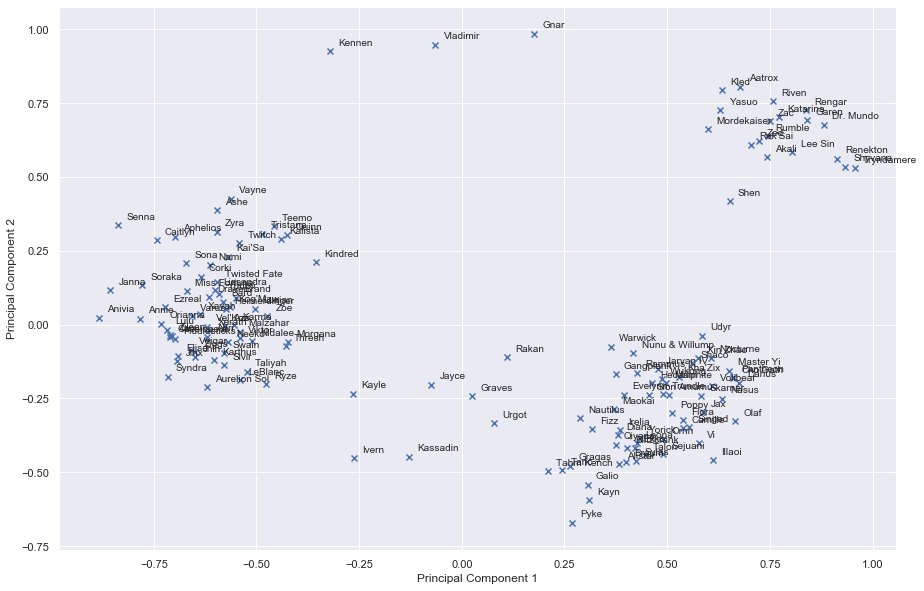

In [17]:
# plotting with minmax scaling
fig, ax = plt.subplots(figsize = (15, 10))

for i, key in enumerate(final_df['name']):
    # instantiates each x and y coordinate
    x_axis = principal_df['principal component 1'][i]
    y_axis = principal_df['principal component 2'][i]
    
    # creates scatterplot points
    ax.scatter(x_axis, y_axis, marker = 'x', color = 'b')
    
    # adds champion name to each point
    ax.text(x_axis + 0.02 , y_axis + 0.02, key, fontsize = 10)


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show();

Interesting! Seems the champions all got grouped in pretty noticeable clusters based on their stats. Let's replace the names and markers with images instead to get a more vivid picture.

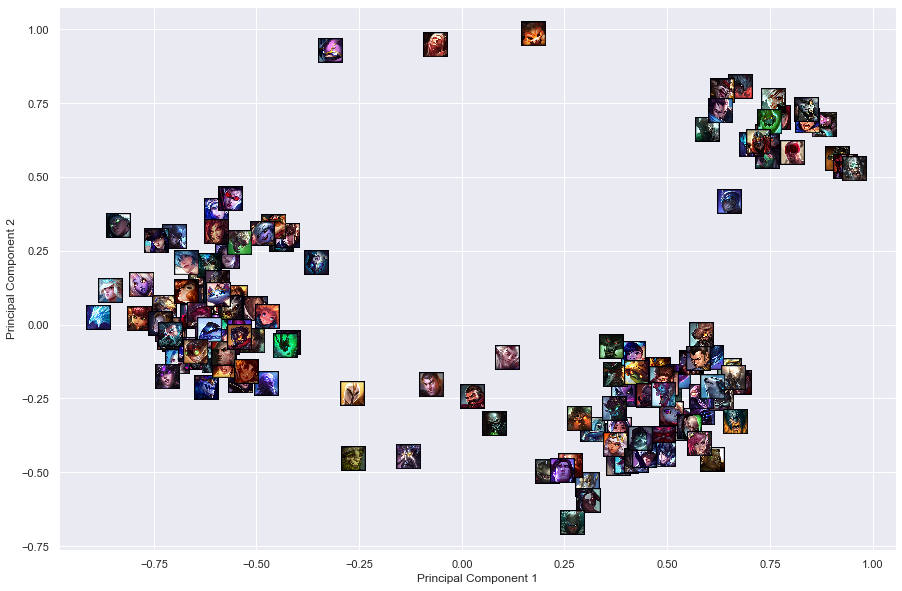

In [18]:
# plotting with minmax scaling
fig, ax = plt.subplots(figsize = (15, 10))

for i, key in enumerate(final_df['name']):
    # instantiates each x and y coordinate
    x_axis = principal_df['principal component 1'][i]
    y_axis = principal_df['principal component 2'][i]
    
    # path to image for each point
    path = 'D:/Python/league_of_legends/icons/' + f'{key}.png'
    
    # creates scatterplot points 
    ax.scatter(x_axis, y_axis, marker = 'x', color = 'b')
    
    # adds image over each point
    ab = AnnotationBbox(get_image(path), (x_axis, y_axis), frameon = False)
    ax.add_artist(ab)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show();

Neat! Champions were essentially grouped into 5 categories:

### Manaless melee champions
The top right corner basically encapsulates all champions that use an alternative resource be it energy, rage, fury and the like. This is probably due to all their mana-related stats being 0. There also seems to be a somewhat divide between ad and ap damage within the cluster, with ad-based champions like Aatrox being above ap-based champions like Mordekaiser. This division may be due to the fact that ap-based champions have less attack speed or attack damage related stats, and is present throughout almost every other cluster.

### Manaless ranged champions
The top center contains a small cluster of ranged champions that do not use mana. I'm guessing that the reason they're separated from the manaless melee champions is because of their higher range, which could be a large factor within component 1.

### Mana melee champions
These champions look mostly to be stereotypical fighter champions with some assassins strewn about. Odd that there really isn't a pattern to be detected from within the cluster.

### Mana ranged champions
Here is probably the clearest distinction between ad and ap damage dealers. I guess when you're ranged you're more likely to be squishy and thus, more pegged to have higher damage of a specific stat?

### Mystery champions
In the center lies 7 champions that don't seem to belong to any other cluster, but don't seem to have much in common with one another. The only common theme is the fact that many of them have both a ranged and melee attack form, like Jayce, Ivern, and Kayle. I'm confused that champions like Nidalee and Elise aren't included in the cluster and am stumped about Rakan, Graves, Urgot, and Kassadin. Perhaps they're so different in other stats that attack range wasn't sufficient to have them grouped with the other champions?

Let's look at a loading plot to see the actual effect each feature has on each component.

In [19]:
# pca loading plot

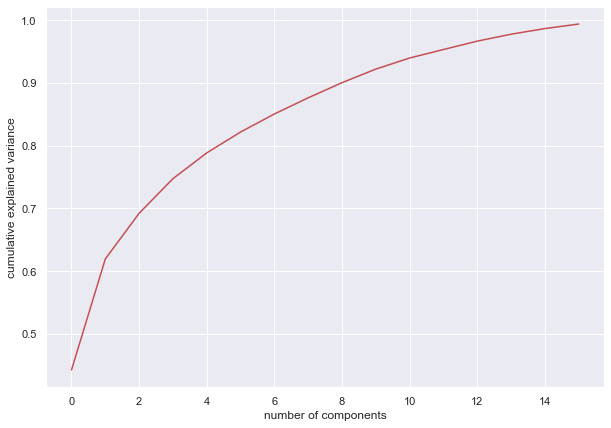

In [20]:
# what if I wanted to know how many components it would take to have 99% explained variance?
pca = PCA(n_components = 0.99, svd_solver = 'full')
principal_components_minmax = pca.fit_transform(x_minmax)

fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(np.cumsum(pca.explained_variance_ratio_), color = 'r')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show();

Apparently with 3 principal components I can have 70% explained variance. Since plotting in 3D will take away a little from interpretability, I think I'll keep it at 2 components for the time being.

## Kmeans Clustering

Now that we saw a visual representation of what clusters of champions could look like, let's input it into kmeans to see what the optimal number of cluster could be while minimizing SSE within each cluster.

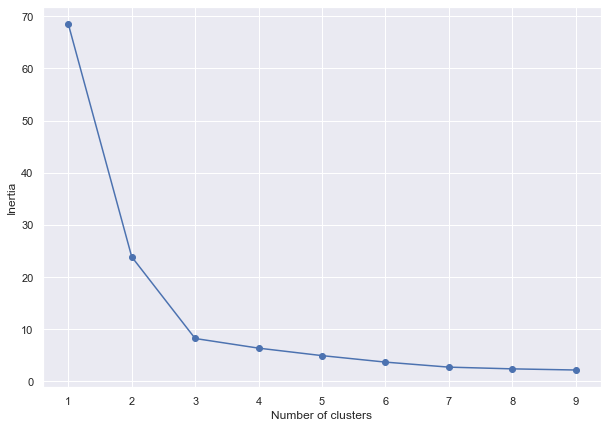

In [21]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init = 'k-means++')
    kmeans.fit(principal_df)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})

# plotting to see the optimal number of clusters
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show();

I can see from the graph that 3 may be the optimal number of clusters, but can also see from the scatterplot above that there seems to be 5 clusters. Let's set the number of cluster to 3 this time and see how kmeans categorizes each champion in the leftover cluster.

In [22]:
# create kmean clustering with k = 3
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
kmeans.fit(principal_df)

y_kmeans = list(kmeans.predict(principal_df))

Because of the way our plotting commands are structured we can't directly set c to kmeans_labels_ as it does not work in a loop. For that reason we'll manually set a color map before we plot.

In [23]:
# setting color map for each label
color_map = {0: 'r', 1: 'k', 2: 'b'}
labels = [color_map[i] for i in y_kmeans]

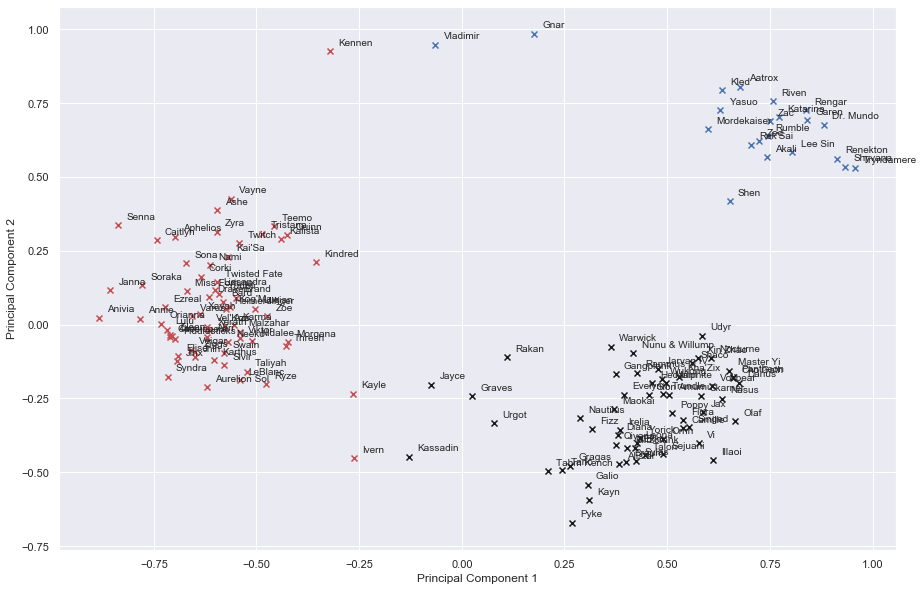

In [24]:
# plotting with clusters
fig, ax = plt.subplots(figsize = (15, 10))

for i, key in enumerate(final_df['name']):
    # instantiates each x and y coordinate
    x_axis = principal_df['principal component 1'][i]
    y_axis = principal_df['principal component 2'][i]
    cluster_color = labels[i]
    
     # creates scatterplot points
    ax.scatter(x_axis, y_axis, marker = 'x', c = cluster_color)
    
    # adds champion name to each point
    ax.text(x_axis + 0.02 , y_axis + 0.02, key, fontsize = 10)


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show();

This clustering makes more sense! The mystery champions in the center all got grouped into suitable clusters, with Kayle and Ivern being ranged and the other four (excluding Urgot) being melee. Urgot does seem to be the black sheep of the group because he's a tanky juggernaut but happens to be ranged like a marksman. I honestly would have trouble classifying him as well to be honest! Lastly, Kennen looks to be more similar to the mana ranged champions than the other non-mana champions. 

## Champion Icons PCA/t-SNE Analysis

Now that I clustered each champion based on their stats, let's see if I can take each champion's image and plot them out to see if similar-looking champions are clustered together.

I first ran some preprocessing on my image folder by reading, flattening, convoluting, and filtering each image so that PCA and t-SNE can better detect certain features. T-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Essentially what this means is that it looks at the original data that is entered into the algorithm and looks at how to best represent this data using less dimensions by matching both distributions.

The way it does this is computationally quite heavy and therefore there are some (serious) limitations to the use of this technique. In case of very high dimensional data like our images, I'll may need to apply another dimensionality reduction technique (aka PCA) before using t-SNE.

In [82]:
# creating image dataframe with RGB values of all pixels
champ_image_pixel_df = preprocess_images('D:/Python/league_of_legends/images/')
champ_image_pixel_df.head()

c:\users\sliu742\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  from ipykernel import kernelapp as app


,name,0,1,2,3,4,5,6,7,8,...,422,423,424,425,426,427,428,429,430,431
0,Aatrox,0.209156,0.242140,0.275124,0.288944,0.332417,0.375890,0.386707,0.450700,0.514692,...,1.610277,3.683465,2.640972,1.598479,4.024220,2.861678,1.699136,4.418305,3.125055,1.831805
1,Ahri,0.038339,0.124313,0.210288,0.091785,0.189008,0.286231,0.182515,0.291134,0.399752,...,1.902648,1.254886,1.394281,1.533676,1.019429,1.093197,1.166965,0.938758,0.976164,1.013570
2,Akali,0.487419,0.642552,0.797686,0.605447,0.780487,0.955528,0.641058,0.823313,1.005567,...,1.464558,1.139446,1.333178,1.526911,1.228535,1.413094,1.597653,1.249179,1.418397,1.587616
3,Alistar,0.235869,0.277301,0.318733,0.333633,0.367137,0.400641,0.414381,0.446925,0.479468,...,2.497692,3.322313,3.177048,3.031783,3.369476,3.212036,3.054595,3.064862,2.922248,2.779633
4,Amumu,0.267192,0.305389,0.343585,0.401244,0.444667,0.488089,0.567537,0.621251,0.674964,...,1.553757,1.206820,1.302447,1.398073,0.937138,1.047666,1.158194,0.736100,0.857265,0.978431


In [83]:
# separating out names and pixel features
champ_names = champ_image_pixel_df['name']
pixels = champ_image_pixel_df.loc[:, champ_image_pixel_df.columns != 'name']

# pca analysis on pixels
pca = PCA(n_components = 0.9, svd_solver = 'full')
principal_components_pixels = pca.fit_transform(pixels)

In [84]:
# how many components are we left with?
principal_components_pixels.shape[1]

9

In [85]:
# tsne
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 20, n_iter = 300)
tsne_results = tsne.fit_transform(principal_components_pixels)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 147 samples in 0.000s...
[t-SNE] Computed neighbors for 147 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 147 / 147
[t-SNE] Mean sigma: 6.308924
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.919434
[t-SNE] KL divergence after 300 iterations: 1.157868


In [88]:
# transforming into df and changing column names
tsne_results_df = pd.DataFrame(tsne_results)
tsne_results_df.rename(columns = {0:'tsne 1', 1:'tsne 2'}, inplace = True)

Now that we have the two resulting dimensions we can again visualise them by creating a scatter plot of the two dimensions and coloring each sample by its respective label.

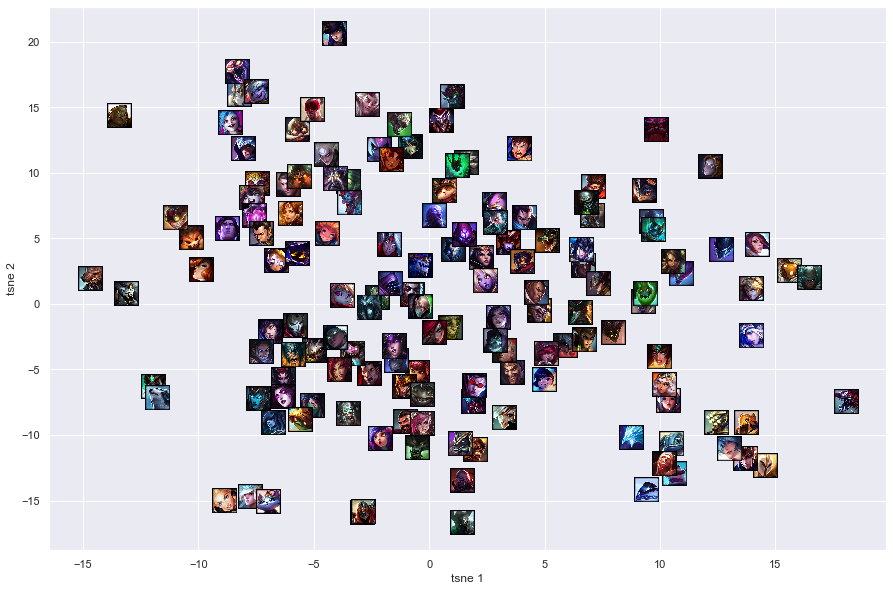

In [87]:
# plotting to see which champions look alike from their icons
fig, ax = plt.subplots(figsize = (15, 10))

for i, key in enumerate(final_df['name']):
    # instantiates each x and y coordinate
    x_axis = tsne_results_df['tsne 1'][i]
    y_axis = tsne_results_df['tsne 2'][i]
    
    # path to icon for each point
    path = 'D:/Python/league_of_legends/icons/' + f'{key}.png'
    
    # creates scatterplot points 
    ax.scatter(x_axis, y_axis, marker = 'x', color = 'b')
    
    # adds image over each point
    ab = AnnotationBbox(get_image(path), (x_axis, y_axis), frameon = False)
    ax.add_artist(ab)

plt.xlabel('tsne 1')
plt.ylabel('tsne 2')

plt.show();